In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/NIR/ods_broadcasts_201905301157.csv.zip" /content/ods_broadcasts_201905301157.csv.zip
!cp "/content/drive/MyDrive/NIR/ods_match_news.csv.zip" /content/ods_match_news.csv.zip
!unzip /content/ods_broadcasts_201905301157.csv.zip
!unzip /content/ods_match_news.csv.zip

Archive:  /content/ods_broadcasts_201905301157.csv.zip
  inflating: ods_broadcasts_201905301157.csv  
Archive:  /content/ods_match_news.csv.zip
  inflating: ods_match_news.csv      


In [ ]:
import pandas as pd
import numpy as np
import nltk
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Подготовка набора данных для первой, второй, третьей и пятой разметки

##### Набор данных текстовых трансляций

In [ ]:
data_broadcasts = pd.read_csv("/content/ods_broadcasts_201905301157.csv")
data_broadcasts

,match_id,team1,team2,name,match_time,type,minute,content,message_time
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"Добрый день! Sports.ru поздравляет всех, кто п...",1237034763
1,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"Будем надеяться, что признаков пресловутого ""в...",1237034996
2,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"Что ж, сегодняшних соперников можно назвать од...",1237035202
3,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,Зимой подмосковный клуб едва не исчез с футбол...,1237035415
4,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,NaN,0,"""Локомотив"" зимой старался стать лучше. В сост...",1237035796
...,...,...,...,...,...,...,...,...,...
722062,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,"<b>2:1 - ""Питтсбург"" выигрывает второй финальн...",1464837758
722063,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,"Очевидно, что залог успеха ""Питтсбурга"" - иниц...",1464837879
722064,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,"Другими словами, ДеБур должен в первую очередь...",1464838029
722065,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,empty,63,Большое спасибо за чтение! До новых встреч на ...,1464838220


In [ ]:
def remove_tags(html):
    soup = BeautifulSoup(str(html), "html.parser")
    
    for data in soup(['style', 'script']):
        data.decompose()

    return ' '.join(soup.stripped_strings)

data_broadcasts['content'] = data_broadcasts['content'].apply(remove_tags)

<ipython-input-5-856332f3cd21>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(html), "html.parser")
<ipython-input-5-856332f3cd21>:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(str(html), "html.parser")


In [ ]:
# количество слов в небольших частях
data_broadcasts['length_part_content'] = data_broadcasts['content'].apply(lambda x: len(str(x).split()))

In [ ]:
data_broadcasts[['length_part_content']].describe()

,length_part_content
count,722067.000000
mean,15.932498
std,10.862535
min,0.000000
25%,9.000000
50%,14.000000
75%,20.000000
max,363.000000


<Axes: xlabel='length_part_content'>

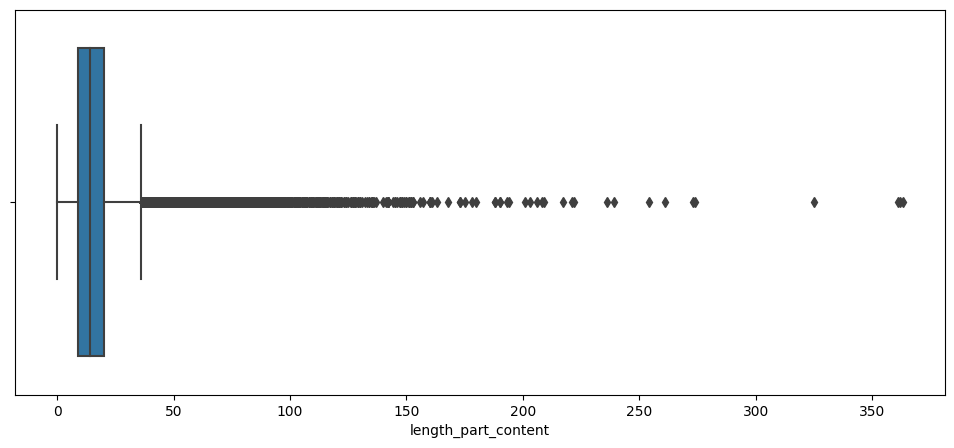

In [ ]:
fig, axes = plt.subplots(figsize=(12, 5))
sns.boxplot(ax=axes, x='length_part_content', data=data_broadcasts)

In [ ]:
lower_length_part_content, upper_length_part_content = data_broadcasts.length_part_content.quantile(0.01), data_broadcasts.length_part_content.quantile(0.99)
print('Длина частей трансляции. Нижняя граница: ', lower_length_part_content, ', верхняя граница: ', upper_length_part_content)

Длина частей трансляции. Нижняя граница:  0.0 , верхняя граница:  54.0


In [ ]:
def first_part_content(messages, size=200):
  result = ""
  for message in messages:
    prep_message = message.strip()
    if len((result + prep_message).split()) < size:
      result += prep_message + " "
    else:
      break
  return result.strip()

def last_part_content(messages, size=200):
  result = ""
  for message in messages[::-1]:
    prep_message = message.strip()
    if len((result + prep_message).split()) < size:
      result = prep_message + " " + result
    else:
      break
  return result.strip()

grouping_columns = ['match_id', 'team1', 'team2', 'name', 'match_time']
data_broadcasts = data_broadcasts.sort_values(['match_id', 'minute', 'message_time'], ascending = True).groupby(grouping_columns)['content'].agg([first_part_content, last_part_content]).reset_index()
data_broadcasts

,match_id,team1,team2,name,match_time,first_part_content,last_part_content
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,"Добрый день! Sports.ru поздравляет всех, кто п...",Драган Блатняк запустил мяч на трибуну со штра...
1,18935,Зенит,Штутгарт,перенесенные матчи,1234977300,"Матчем со ""Штутгартом"" ""Зенит"" открывает европ...",Шибер впереди пока никак не зацепится за мяч. ...
2,18936,Астон Вилла,ЦСКА,перенесенные матчи,1234983600,"Интересный парадокс жребия - армейцам, единств...",Люк Янг заработал на Карвальо желтую карточку!...
3,18941,Шахтер,Тоттенхэм,перенесенные матчи,1235069100,Приветствуем Всех любителей самой популярной и...,"По количеству нарушений, можно сказать, что фу..."
4,18956,Штутгарт,Зенит,перенесенные матчи,1235677500,"Ответный матч 1/16 финала Кубка УЕФА ""Зенита"" ...",Гомес толкнул Крижанаца в верховой борьбе. Нап...
...,...,...,...,...,...,...,...
8776,1104438,Томь,Кубань,Россия. Премьер-лига,1464354000,Привет. Теперь точно – сегодня последний тур Р...,Самое ужасное в этой ситуации – потенциальная ...
8777,1104439,Волгарь,Анжи,Россия. Премьер-лига,1464102000,Всем привет! Стыковые матчи за право выступать...,"Алейник уступает место Петровичу, известному п..."
8778,1104440,Анжи,Волгарь,Россия. Премьер-лига,1464364800,Всем привет! Сегодня важный день для российско...,В опасном подкате Зуйков сбивает с ног Маевско...
8779,1104865,Питтсбург,Сан-Хосе,Кубок Стэнли,1464652800,"Привет всем, кто не представляет своей жизни б...","""Сан Хосе"" не помогает и замена вратаря. Плюс ..."


In [ ]:
data_broadcasts.iloc[0]['first_part_content']

'Добрый день! Sports.ru поздравляет всех, кто прошедшей зимой с нетерпением считал дни до старта российской премьер-лиги. Наша первая текстовая трансляция чемпионата 2009 поможет Вам проследить за событиями, который произойдут на стадионе "Локомотив", где одноименная команда принимает гостей из "Химок". Будем надеяться, что признаков пресловутого "весеннего" футбола на "Локомотиве" сегодня будет меньше, нежели на других аренах страны. Погода в Москве солнечная, почти тепло, да и стадион принято называть лучшим в стране, а это значит, что газон должен быть в порядке. Что ж, сегодняшних соперников можно назвать одними из самых загадочных команд сезона. Но загадочность проявляетя в них совершенно по-разному. Если болельщики хозяев верят, что кризисные времена ушли в прошлое, и команда в этом году наконец-то отважится на чемпионский выстрел, то химкинские поклонники пока находятся в полном неведении. Зимой подмосковный клуб едва не исчез с футбольной карты, но затем минимальный прожиточный

In [ ]:
data_broadcasts.iloc[0]['last_part_content']

'Драган Блатняк запустил мяч на трибуну со штрафного. Билялетдинов мощно запустил мяч в ближний угол. Березовский по-прежнему хорош! А пас Динияру выдавал Торбинский. Так, пошла заключительная пятиминутка. Сейчас "Локо" старается придавить соперника, который максимально концентрирует усилия в обороне. Будет штурм? Штурма пока нет. Есть водопой. Родолфо лежит на траве. 4 минуты добавлено. Сейчас будет опасный штрафной в сторону ворот Березовского. Завалили Торбинского. Мяч посылается на левый фланг, откуда Одемвинги приложился в соперника. БЛАТНЯК! Он легко уходит от Фининьо и бьет в ближний угол. Чех не очень ловким движением отбивает мяч. ВОЗНЯ В ШТРАФНОЙ "ХИМОК"! Мяч летит в ШТАНГУ, а потом Николаев дает финальный свисток. Одемвинги, находясь прямо в центре штрафной, не придумал ничего лучше, чем откатить мяч в район центрального круга. Рашид Рахимов сейчас говорит, что изменения в игре "Локомотива" налицо, и утверждает, что результат матч нелогичен. "Локомотив", имея территориальное

In [ ]:
data_broadcasts.iloc[30]['first_part_content']

'Привет! Если вы вдруг сейчас слегка приболели из-за нестабильной погоды и обмотались красно-сине-черным шарфом, то скорей определитесь! Либо синий, либо черный цвет будет лишним. ЦСКА - "Химки"! Армейцам нынче едва ли позавидуешь больше, чем "Химкам". Ну, ладно, больше. Но все равно! В последних матчах вымучивают победы над середняками, коими являются "Томь" и "Ростов", и проигрывают прямым конкурентам в борьбе за медали: 1:2 от "Спартака" и "Локомотива". Правда, в прошлом туре подопечные Зико были куда ближе к победе, чем даже к ничьей, но, упустив на исходе встречи совместно с лайнсменом резвого Сычева, остались ни с чем. "Химки" же, пытаясь стряхнуть с себя мучительный воз поражений, прикупили чемпиона мира по пляжному футболу и ямайского форварда. Ситуация критическая. Удачи! В первом круге Красич разобрался с подмосквичами в одиночку, сотворив хет-трик. Может, сегодня проснется Вагнер Лав? Негоже такому страйкеру столько времени без гола оставаться. Всколыхнув левый фланг атаки а

In [ ]:
data_broadcasts.iloc[30]['last_part_content']

'Армейцам удалось вернуть контроль над мячом. Дотерпеть минут десять осталось. Гонсалес уступает место на фланге Щенникову. Пропал с наших радаров Марк во втором тайме. Дзагоев загубил контратаку, не сумев выдать пас на ход Вагнеру Лаву! После ответного мяча "Химок" игра у москвичей опрокинулась. На удержание играют теперь. Щенников прострелил на Дзагоева. Удар с отклонением! Комаров переводит на угловой. Ромащенко на лихом коне в штрафной! Перебрасывает Акинфеева на дальнюю штангу, оттуда прострел! Отбились армейцы. Вагнер вывалился один на один после скидки Дзагоева! Тут лайнсмен углядел офсайд. Да и Комаров спасал. Ну, что, все так и закончится? В середине поля катают мяч соперники. "Химки" давят! Безбородов видит нарушение со стороны Низамутдинова. Угловой не смогли точно подать подмосквичи на последней минуте. Все! 2:1 - мучительная победа армейцев. Эх, Дзагоев, Дзагоев... Тысячу минут стоял один перед воротами с мячом! И, дождавшись защитника, отдал неточный пас. Зико прав, говор

In [ ]:
data_broadcasts.iloc[1500]['first_part_content']

'Салют, амигос! Испанский сезон после тяжелого, бурного и праздничного межсезонья открывает свои двери первым матчем за национальный Суперкубок: "Севилья" - "Барселона"! Представляете себя в роли деда Мороза, который весь Новый Год в красной шубе усердно тряс бородой, хлестал оленей и заставлял читать стишки детей, непременно потом вытаскивая для них подарки из увесистого рюкзака? А потом, развеселив всю округу тяжким трудом, принялся гулять до подъелочного состояния? Представили? Вот сейчас почти каждый игрок "Блауграны", как такой дед Мороз после новогоднего буйства. Межсезонка выдалась сверхнасыщенной и мегауспешной. Тренироваться к этому сезону почти не пришлось - сразу в бой, отстаивать Кубок, добытый в прошлом году в играх с "Атлетиком"! "Севилья" - известный кубковый боец. Поглядим, чем дело обернется? Поехали! Каталонцы поджали соперника к его штрафной. Где там голова Ибрагимовича? Йерро по правую руку от Дель Боске внимательно смотрит за первым дальним ударом Хесуса Наваса. Не

In [ ]:
data_broadcasts.iloc[1500]['last_part_content']

'Мяч полетал по штрафной "Севильи", а с ударом Кркича вылетел за лицевую. Негредо вместо Фабиану. Желтая для Чигарини за жесткий подкат. ГООООЛ! Кануте подставляет ногу под своевременный прострел и мяч окунается в сетку рядом с ничего не успевшим сообразить Миньо! Месси не хватило росточка дотянуться до подачи на линию вратарской. Долго каталонцы строили атаку. А когда мяч достиг Кркича, Боян стукнул сгоряча в дальний! И промахнулся. Адриано сменил Милито. Он не мог не выйти. И КАНУТЕ!!! 3:1! Вот дела! Навас пасом пяткой обезвредил двоих защитников, кросс без помех слева, и Кануте уверенным кивком забивает третий! Перротти! Прорыв по флангу, вход в штрафную, удар с левой! В сетку с внешней стороны. Навас пошел прямиком на защитника каталонцев, но тот не пустил Хесуса себе за спину. Месси! Стрельнул с порога штрафной! Выше. Кейте производит подготовленный удар с дистанции! Хорош сэйв Палопа. Блестящий гол, барселонский! Через перепасовку во вратарской! Жаль, что офсайд. Месси отвовевал 

##### Набор данных новостей

In [ ]:
data_news = pd.read_csv('/content/ods_match_news.csv')
data_news

,id,name,ctime,body,match_id
0,7005921,Зико: &laquo;Задача может быть только одна: пр...,2009-02-18 01:06:26,<p>Главный тренер ЦСКА Зико поделился мыслями ...,18936
1,7005943,Текстовые онлайны матчей &#171;Зенит&#187; &#1...,2009-02-18 01:08:20,<p>Сегодня на Sports.ru дебютируют текстовые о...,18935
2,7005943,Текстовые онлайны матчей &#171;Зенит&#187; &#1...,2009-02-18 01:08:20,<p>Сегодня на Sports.ru дебютируют текстовые о...,18936
3,7006022,Стилян Петров: &laquo;ЦСКА выиграл все матчи в...,2009-02-18 01:21:55,<p>Полузащитник &#171;Астон Виллы&#187; Стилян...,18936
4,7006398,Хиддинк постетит матч &laquo;Астон Виллы&raquo...,2009-02-18 03:17:23,<p>Главный тренер сборной России и &#171;Челси...,18936
...,...,...,...,...,...
92992,1040645221,Петр Чех: Если бы пропустил от Денисова — это ...,2016-06-02 14:44:24,"<p class=""text"">Голкипер сборной Чехии Петр Че...",1095139
92993,1040648050,"Конор Шери: &laquo;Кросби сказал, что выиграет...",2016-06-02 16:17:07,"<p>Форвард <a class=""link-news2tags"" href=""htt...",1104866
92994,1040648436,Сидни Кросби: &laquo;Победным голом мы больше ...,2016-06-02 16:29:35,"<p>Капитан <a class=""link-news2tags"" href=""htt...",1104866
92995,1040653602,Джастин Браун: &laquo;Питтсбург&raquo; все нас...,2016-06-02 19:36:29,<p>Защитник «Сан-Хосе» Джастин Браун оценил хо...,1104866


In [ ]:
# Удалим новости, которые не содержат текста
data_news.dropna(axis=0, how='any', subset=['body'], inplace=True)

data_news['name'] = data_news['name'].apply(remove_tags)
data_news['body'] = data_news['body'].apply(remove_tags)

data_news['body'] = data_news['body'].apply(lambda x: str(x).replace(' \x96', ""))
data_news.iloc[1]['body']

<ipython-input-5-856332f3cd21>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(html), "html.parser")


'Сегодня на Sports.ru дебютируют текстовые онлайны матчей Кубка УЕФА , кроме того, на сайте продолжится тестирование трансляций чемпионата Англии . За всеми значимыми событиями (голы, замены, предупреждения и т.д.) всех матчей дня вы сможете следить на страницах онлайнов, обмениваясь по ходу впечатлениями в матч-чате. Попасть на страницы текстовых трансляций вы можете через страницу матч-центра либо с помощью информационного блока непосредственно под главным меню. При этом для трех матчей предусмотрены подробнейшие текстовые трансляции: это «Зенит» «Штутгарт» (онлайн начинается в 19.45), «Астон Вилла» ЦСКА (начало в 21.30) и «Манчестер Юнайтед» «Фулхэм» (начало в 22.30). Заранее приносим извинения за возможные на этапе бета-тестирования ошибки и призываем тех, кто их заметил, писать на support@sports.ru.'

In [ ]:
data_news['length_news_name'] = data_news['name'].apply(lambda x: len(x.split()))
data_news['length_body'] = data_news['body'].apply(lambda x: len(x.split()))
data_news[['length_news_name', 'length_body']].describe()

,length_news_name,length_body
count,92995.000000,92995.000000
mean,10.567256,113.735502
std,3.139614,74.275862
min,3.000000,0.000000
25%,8.000000,63.000000
50%,10.000000,94.000000
75%,12.000000,142.000000
max,28.000000,1249.000000


<Axes: xlabel='length_body'>

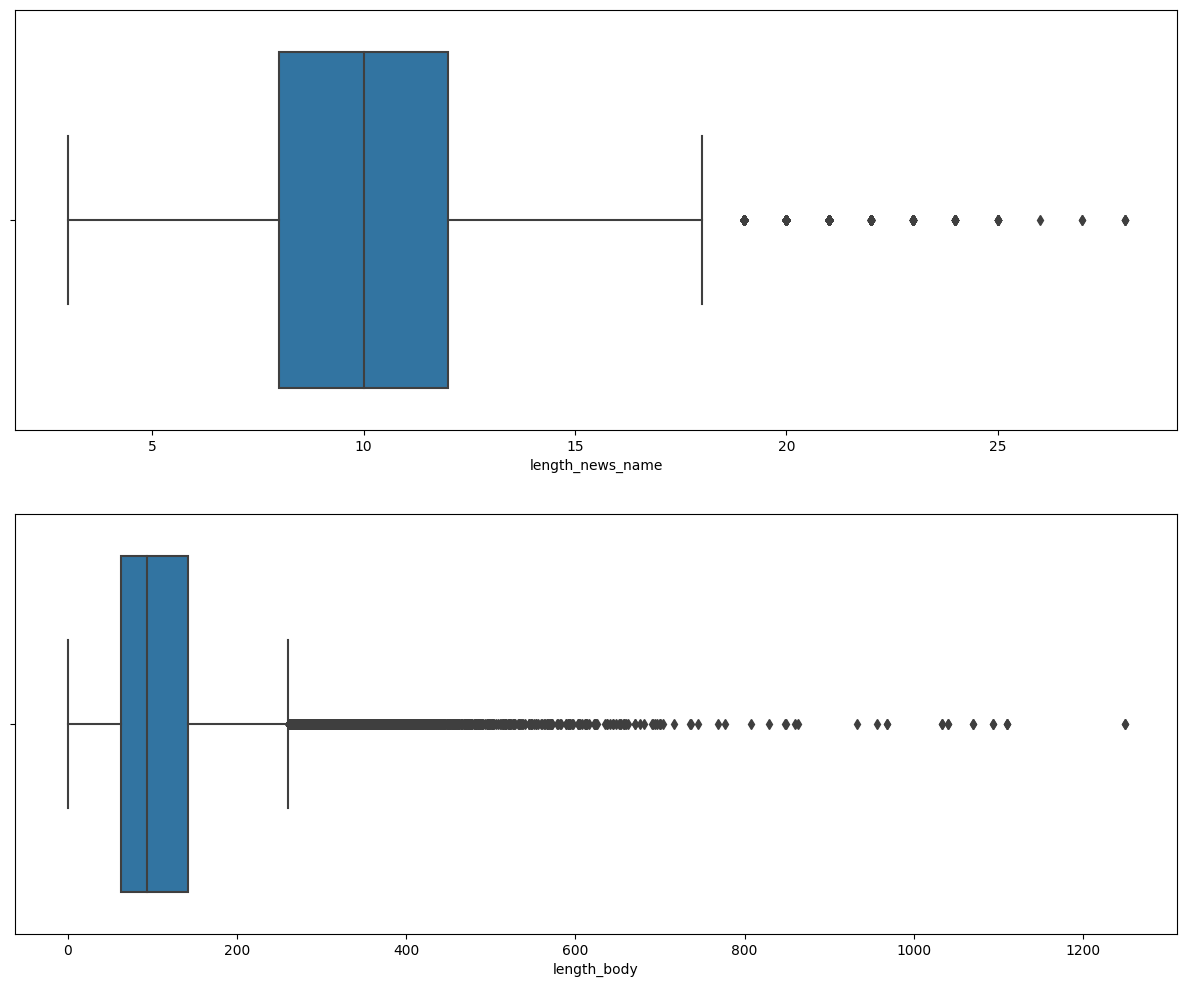

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

sns.boxplot(ax=axes[0], x='length_news_name', data=data_news)
sns.boxplot(ax=axes[1], x='length_body', data=data_news)

In [ ]:
size_body = 80
data_news['part_body'] =  data_news['name'] +  '. ' + data_news['body'].apply(lambda x: ' '.join(x.split()[:size_body]))
data_news

,id,name,ctime,body,match_id,length_news_name,length_body,part_body
0,7005921,Зико: «Задача может быть только одна: пройти в...,2009-02-18 01:06:26,Главный тренер ЦСКА Зико поделился мыслями о п...,18936,10,113,Зико: «Задача может быть только одна: пройти в...
1,7005943,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,...",2009-02-18 01:08:20,Сегодня на Sports.ru дебютируют текстовые онла...,18935,18,110,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,..."
2,7005943,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,...",2009-02-18 01:08:20,Сегодня на Sports.ru дебютируют текстовые онла...,18936,18,110,"Текстовые онлайны матчей «Зенит» – «Штутгарт»,..."
3,7006022,Стилян Петров: «ЦСКА выиграл все матчи в этом ...,2009-02-18 01:21:55,Полузащитник «Астон Виллы» Стилян Петров подел...,18936,13,157,Стилян Петров: «ЦСКА выиграл все матчи в этом ...
4,7006398,Хиддинк постетит матч «Астон Виллы» и ЦСКА,2009-02-18 03:17:23,Главный тренер сборной России и «Челси» Гус Хи...,18936,7,57,Хиддинк постетит матч «Астон Виллы» и ЦСКА. Гл...
...,...,...,...,...,...,...,...,...
92992,1040645221,Петр Чех: Если бы пропустил от Денисова — это ...,2016-06-02 14:44:24,Голкипер сборной Чехии Петр Чех после победы в...,1095139,12,199,Петр Чех: Если бы пропустил от Денисова — это ...
92993,1040648050,"Конор Шери: «Кросби сказал, что выиграет вбрас...",2016-06-02 16:17:07,Форвард «Питтсбурга» Конор Шери прокомментиров...,1104866,16,54,"Конор Шери: «Кросби сказал, что выиграет вбрас..."
92994,1040648436,Сидни Кросби: «Победным голом мы больше обязан...,2016-06-02 16:29:35,Капитан «Питтсбурга» Сидни Кросби прокомментир...,1104866,12,92,Сидни Кросби: «Победным голом мы больше обязан...
92995,1040653602,Джастин Браун: «Питтсбург» все наступал и наст...,2016-06-02 19:36:29,Защитник «Сан-Хосе» Джастин Браун оценил ход с...,1104866,10,56,Джастин Браун: «Питтсбург» все наступал и наст...


In [ ]:
data_news.iloc[0]['part_body']

'Зико: «Задача может быть только одна: пройти в следующую стадию». Главный тренер ЦСКА Зико поделился мыслями о предстоящем матче с «Астон Виллой» в 1/16 финала Кубка УЕФА. «Все серии когда-нибудь кончаются. «Астон Вилла» играет дома, при своих болельщиках, уверен, легче от того, что беспроигрышная серия англичан в премьер-лиге прервалась, нам не будет. Как планируем остановить Агбонлахора и Янга? Команда идет на третьем месте в чемпионате Англии, и это заслуга не одного игрока, а всего коллектива. Внимание надо уделять всем. Хотя, конечно, если дать свободу тому же Эшли Янгу, можем получить'

##### Общий набор данных

In [ ]:
data = pd.merge(data_broadcasts, data_news, on="match_id", how="inner")
data.rename(columns = {'name_x' : 'broadcast_name', 'name_y' : 'news_name'}, inplace = True)

In [ ]:
data['ctime'] = pd.to_datetime(data['ctime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

data['match_time'] = data['match_time'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['match_time'] = pd.to_datetime(data['match_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

data['after_match'] = data['ctime'] - data['match_time']
data['after_match'] = data['after_match'].apply(lambda x: 1 if x.total_seconds() > 0 else 0)

In [ ]:
data = data[['match_id', 'id', 'team1', 'team2', 'broadcast_name', 'first_part_content', 'last_part_content', 'part_body', 'after_match']]
data

,match_id,id,team1,team2,broadcast_name,first_part_content,last_part_content,part_body,after_match
0,18925,7267034,Локомотив,Химки,Россия. Премьер-лига,"Добрый день! Sports.ru поздравляет всех, кто п...",Драган Блатняк запустил мяч на трибуну со штра...,Три тысячи сотрудников милиции будут следить з...,0
1,18925,7269714,Локомотив,Химки,Россия. Премьер-лига,"Добрый день! Sports.ru поздравляет всех, кто п...",Драган Блатняк запустил мяч на трибуну со штра...,Текстовый онлайн матча «Атлетик» – «Реал» – на...,0
2,18925,7270558,Локомотив,Химки,Россия. Премьер-лига,"Добрый день! Sports.ru поздравляет всех, кто п...",Драган Блатняк запустил мяч на трибуну со штра...,Премьер-лига. 1-й тур. «Терек» обыграл «Спарта...,0
3,18925,7274151,Локомотив,Химки,Россия. Премьер-лига,"Добрый день! Sports.ru поздравляет всех, кто п...",Драган Блатняк запустил мяч на трибуну со штра...,Дюрица получил травму в игре с «Химками». Защи...,1
4,18925,7274661,Локомотив,Химки,Россия. Премьер-лига,"Добрый день! Sports.ru поздравляет всех, кто п...",Драган Блатняк запустил мяч на трибуну со штра...,Константин Сарсания: «Если бы выпустил второго...,1
...,...,...,...,...,...,...,...,...,...
92990,1104866,1040642045,Питтсбург,Сан-Хосе,Кубок Стэнли,"Привет всем, кто не представляет своей жизни б...","Совершенно фантастический вклад в победы ""Питт...",Майк Салливан: «Атака – козырь «Сан-Хосе» и мы...,1
92991,1104866,1040648050,Питтсбург,Сан-Хосе,Кубок Стэнли,"Привет всем, кто не представляет своей жизни б...","Совершенно фантастический вклад в победы ""Питт...","Конор Шери: «Кросби сказал, что выиграет вбрас...",1
92992,1104866,1040648436,Питтсбург,Сан-Хосе,Кубок Стэнли,"Привет всем, кто не представляет своей жизни б...","Совершенно фантастический вклад в победы ""Питт...",Сидни Кросби: «Победным голом мы больше обязан...,1
92993,1104866,1040653602,Питтсбург,Сан-Хосе,Кубок Стэнли,"Привет всем, кто не представляет своей жизни б...","Совершенно фантастический вклад в победы ""Питт...",Джастин Браун: «Питтсбург» все наступал и наст...,1


In [ ]:
# сохранение набора данных
# набор данных подготовлен для разметки: релевантных новостей; новостей, которые посвящены всему матчу; новостей-интервью
# набор данных уже содержит разметку новостей, которые были до начала матча (0 - новость до начала матча, 1 - во время матча или после)
data.to_csv('/content/drive/MyDrive/NIR/data(markup 1, 2, 3, 5).csv', index=False, encoding='utf-8')

#### Подготовка набора данных для четвертой разметки

In [ ]:
data_broadcasts = pd.read_csv("/content/ods_broadcasts_201905301157.csv")

def remove_tags(html):
    soup = BeautifulSoup(str(html), "html.parser")
    
    for data in soup(['style', 'script']):
        data.decompose()

    return ' '.join(soup.stripped_strings)

data_broadcasts['content'] = data_broadcasts['content'].apply(remove_tags)
data_broadcasts = data_broadcasts.sort_values(['match_id', 'minute', 'message_time'], ascending = True)

<ipython-input-26-d49c4f63e8a2>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(html), "html.parser")
<ipython-input-26-d49c4f63e8a2>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(str(html), "html.parser")


In [ ]:
grouping_columns = ['match_id', 'team1', 'team2', 'name', 'match_time']
data_broadcasts['row_group'] = (data_broadcasts.sort_values(['match_id', 'minute', 'message_time'], ascending = True).groupby(grouping_columns).cumcount() + 1) // 10

In [ ]:
def first_part_content(messages, size=200):
  result = ""
  for message in messages:
    prep_message = message.strip()
    if len((result + prep_message).split()) < size:
      result += prep_message + " "
    else:
      break
  return result.strip()

grouping_columns = ['match_id', 'team1', 'team2', 'name', 'match_time', 'row_group']
data_broadcasts = data_broadcasts.sort_values(['match_id', 'minute', 'message_time'], ascending = True).groupby(grouping_columns)['content'].apply(first_part_content).reset_index()
data_broadcasts

,match_id,team1,team2,name,match_time,row_group,content
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,0,"Добрый день! Sports.ru поздравляет всех, кто п..."
1,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,1,"На верхнем ярусе одной из центральных трибун, ..."
2,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,2,Глушакова сбивают на линии штрафной. Опасный с...
3,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,3,"ДЮРИЦА! Что же ты делаешь! Крайний защитник ""Л..."
4,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,4,"""Химки"" реализовали свой единственный шанс, ес..."
...,...,...,...,...,...,...,...
77020,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,6,Тренер Салливан создал за короткий срок неверо...
77021,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,7,"Ух ты, болельщик ""Пенс"" в рубашке Шлегра! Рари..."
77022,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,8,"Хернквист ищет, ищет свой шанс на пятаке, и дв..."
77023,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,9,"""Акулам"" все же удалось немного перебросать ""п..."


In [ ]:
data_news['news'] = data_news['name'] + ". " + data_news['body']

In [ ]:
data = pd.merge(data_broadcasts, data_news, on="match_id", how="inner")
data.rename(columns = {'name_x' : 'broadcast_name', 'name_y' : 'news_name'}, inplace = True)
data

,match_id,team1,team2,broadcast_name,match_time,row_group,content,id,news_name,ctime,body,length_news_name,length_body,part_body,news
0,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,0,"Добрый день! Sports.ru поздравляет всех, кто п...",7267034,Три тысячи сотрудников милиции будут следить з...,2009-03-13 22:17:53,Более трех тысяч сотрудников столичной милиции...,15,132,Три тысячи сотрудников милиции будут следить з...,Три тысячи сотрудников милиции будут следить з...
1,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,0,"Добрый день! Sports.ru поздравляет всех, кто п...",7269714,Текстовый онлайн матча «Атлетик» – «Реал» – на...,2009-03-14 03:45:43,Сегодня Sports.ru продолжит текстовые трансляц...,9,134,Текстовый онлайн матча «Атлетик» – «Реал» – на...,Текстовый онлайн матча «Атлетик» – «Реал» – на...
2,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,0,"Добрый день! Sports.ru поздравляет всех, кто п...",7270558,Премьер-лига. 1-й тур. «Терек» обыграл «Спарта...,2009-03-14 10:22:27,1-й тур ПРИМЕЧАНИЕ: время начала матчей – моск...,21,208,Премьер-лига. 1-й тур. «Терек» обыграл «Спарта...,Премьер-лига. 1-й тур. «Терек» обыграл «Спарта...
3,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,0,"Добрый день! Sports.ru поздравляет всех, кто п...",7274151,Дюрица получил травму в игре с «Химками»,2009-03-14 17:48:18,Защитник «Локомотива» Ян Дюрица получил травму...,7,46,Дюрица получил травму в игре с «Химками». Защи...,Дюрица получил травму в игре с «Химками». Защи...
4,18925,Локомотив,Химки,Россия. Премьер-лига,1237037400,0,"Добрый день! Sports.ru поздравляет всех, кто п...",7274661,Константин Сарсания: «Если бы выпустил второго...,2009-03-14 18:34:35,Главный тренер «Химок» Константин Сарсания про...,14,69,Константин Сарсания: «Если бы выпустил второго...,Константин Сарсания: «Если бы выпустил второго...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844745,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,10,Большое спасибо за чтение! До новых встреч на ...,1040642045,Майк Салливан: «Атака – козырь «Сан-Хосе» и мы...,2016-06-02 12:46:34,Главный тренер «Питтсбурга» Майк Салливан прок...,14,105,Майк Салливан: «Атака – козырь «Сан-Хосе» и мы...,Майк Салливан: «Атака – козырь «Сан-Хосе» и мы...
844746,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,10,Большое спасибо за чтение! До новых встреч на ...,1040648050,"Конор Шери: «Кросби сказал, что выиграет вбрас...",2016-06-02 16:17:07,Форвард «Питтсбурга» Конор Шери прокомментиров...,16,54,"Конор Шери: «Кросби сказал, что выиграет вбрас...","Конор Шери: «Кросби сказал, что выиграет вбрас..."
844747,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,10,Большое спасибо за чтение! До новых встреч на ...,1040648436,Сидни Кросби: «Победным голом мы больше обязан...,2016-06-02 16:29:35,Капитан «Питтсбурга» Сидни Кросби прокомментир...,12,92,Сидни Кросби: «Победным голом мы больше обязан...,Сидни Кросби: «Победным голом мы больше обязан...
844748,1104866,Питтсбург,Сан-Хосе,Кубок Стэнли,1464825600,10,Большое спасибо за чтение! До новых встреч на ...,1040653602,Джастин Браун: «Питтсбург» все наступал и наст...,2016-06-02 19:36:29,Защитник «Сан-Хосе» Джастин Браун оценил ход с...,10,56,Джастин Браун: «Питтсбург» все наступал и наст...,Джастин Браун: «Питтсбург» все наступал и наст...


In [ ]:
data = data[['match_id', 'id', 'team1', 'team2', 'broadcast_name', 'row_group', 'content', 'part_body']].sort_values(['match_id', 'id', 'row_group'], ascending = True)
data

,match_id,id,team1,team2,broadcast_name,row_group,content,part_body
0,18925,7267034,Локомотив,Химки,Россия. Премьер-лига,0,"Добрый день! Sports.ru поздравляет всех, кто п...",Три тысячи сотрудников милиции будут следить з...
14,18925,7267034,Локомотив,Химки,Россия. Премьер-лига,1,"На верхнем ярусе одной из центральных трибун, ...",Три тысячи сотрудников милиции будут следить з...
28,18925,7267034,Локомотив,Химки,Россия. Премьер-лига,2,Глушакова сбивают на линии штрафной. Опасный с...,Три тысячи сотрудников милиции будут следить з...
42,18925,7267034,Локомотив,Химки,Россия. Премьер-лига,3,"ДЮРИЦА! Что же ты делаешь! Крайний защитник ""Л...",Три тысячи сотрудников милиции будут следить з...
56,18925,7267034,Локомотив,Химки,Россия. Премьер-лига,4,"""Химки"" реализовали свой единственный шанс, ес...",Три тысячи сотрудников милиции будут следить з...
...,...,...,...,...,...,...,...,...
844653,1104866,1040658199,Питтсбург,Сан-Хосе,Кубок Стэнли,6,Тренер Салливан создал за короткий срок неверо...,Майк Салливан: «Кросби жульничает? Он не делае...
844677,1104866,1040658199,Питтсбург,Сан-Хосе,Кубок Стэнли,7,"Ух ты, болельщик ""Пенс"" в рубашке Шлегра! Рари...",Майк Салливан: «Кросби жульничает? Он не делае...
844701,1104866,1040658199,Питтсбург,Сан-Хосе,Кубок Стэнли,8,"Хернквист ищет, ищет свой шанс на пятаке, и дв...",Майк Салливан: «Кросби жульничает? Он не делае...
844725,1104866,1040658199,Питтсбург,Сан-Хосе,Кубок Стэнли,9,"""Акулам"" все же удалось немного перебросать ""п...",Майк Салливан: «Кросби жульничает? Он не делае...


In [ ]:
# сохранение набора данных
# набор данных подготовлен для разметки: релевантных новостей; новостей, которые посвящены всему матчу; новостей-интервью
# набор данных уже содержит разметку новостей, которые были до начала матча (0 - новость до начала матча, 1 - во время матча или после)
data.to_csv('data(markup 4).csv', index=False, encoding='utf-8')

In [ ]:
!zip -r "/content/data(markup 4).zip" "/content/data(markup 4).csv"

  adding: content/data(markup 4).csv (deflated 94%)


In [ ]:
!cp "/content/data(markup 4).zip" "/content/drive/MyDrive/NIR/data(markup 4).zip"